In [1]:
!python --version

Python 3.10.6


In [2]:
!nvidia-smi

Sat Jul 15 13:37:38 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 Ti     Off | 00000000:01:00.0  On |                  N/A |
|  0%   49C    P5              13W / 125W |    612MiB /  6144MiB |     31%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [9]:
import os
HOME = os.getcwd()
print(HOME)

/home/darth/MLAI-projects/yolo_conveyor/yolo_conveyor_belt


In [4]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.81 🚀 Python-3.10.6 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 5934MiB)
Setup complete ✅ (4 CPUs, 31.2 GB RAM, 204.7/227.7 GB disk)


### Installing and importing Bytetrack

In [7]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
# !sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

/home/darth/MLAI-projects/yolo_conveyor/yolo_conveyor_belt
fatal: destination path 'ByteTrack' already exists and is not an empty directory.


/home/darth/MLAI-projects/yolo_conveyor/yolo_conveyor_belt/ByteTrack
/home/darth/MLAI-projects/yolo_conveyor/envyolo/lib/python3.10/site-packages/setuptools/command/easy_install.py:158: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/home/darth/MLAI-projects/yolo_conveyor/envyolo/lib/python3.10/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
package init file 'videos/__init__.py' not found (or not a regular file)
package init file 'tools/__init__.py' not found (or not a regular file)
package init file 'tutorials/__init__.py' not found (or not a regular file)
package init file 'build/__init__.py' not found (or not a regular file)
package init file 'datasets/__init__.py' not found (or not a regular file)
package init file 'exps/__init__.py' not found (or not a regular file)

In [2]:
# pip uninstall numpy
# pip install -U numpy==1.23.5

In [2]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

### Installing and importing Supervision

In [3]:
# !pip install supervision==0.1.0

In [4]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

### Tracking utils

In [5]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

### Loading pretrained yolov8

In [27]:
MODEL = "runs/detect/train17/weights/best.pt"

In [28]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


### Predict and annotate video

In [75]:
# settings
LINE_START = Point(0, 425)
LINE_END = Point(1280, 475)

SOURCE_VIDEO_PATH = f"{HOME}/raw_video/conveyor_chocolate.mp4"
TARGET_VIDEO_PATH = f"{HOME}/videos/annotated_video.mp4"

In [76]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1280, height=720, fps=25, total_frames=457)

In [77]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [0]

In [78]:
# model.conf = 0.7 # setting custom threshold


0: 384x640 34 chocolates, 8.4ms
Speed: 100.9ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


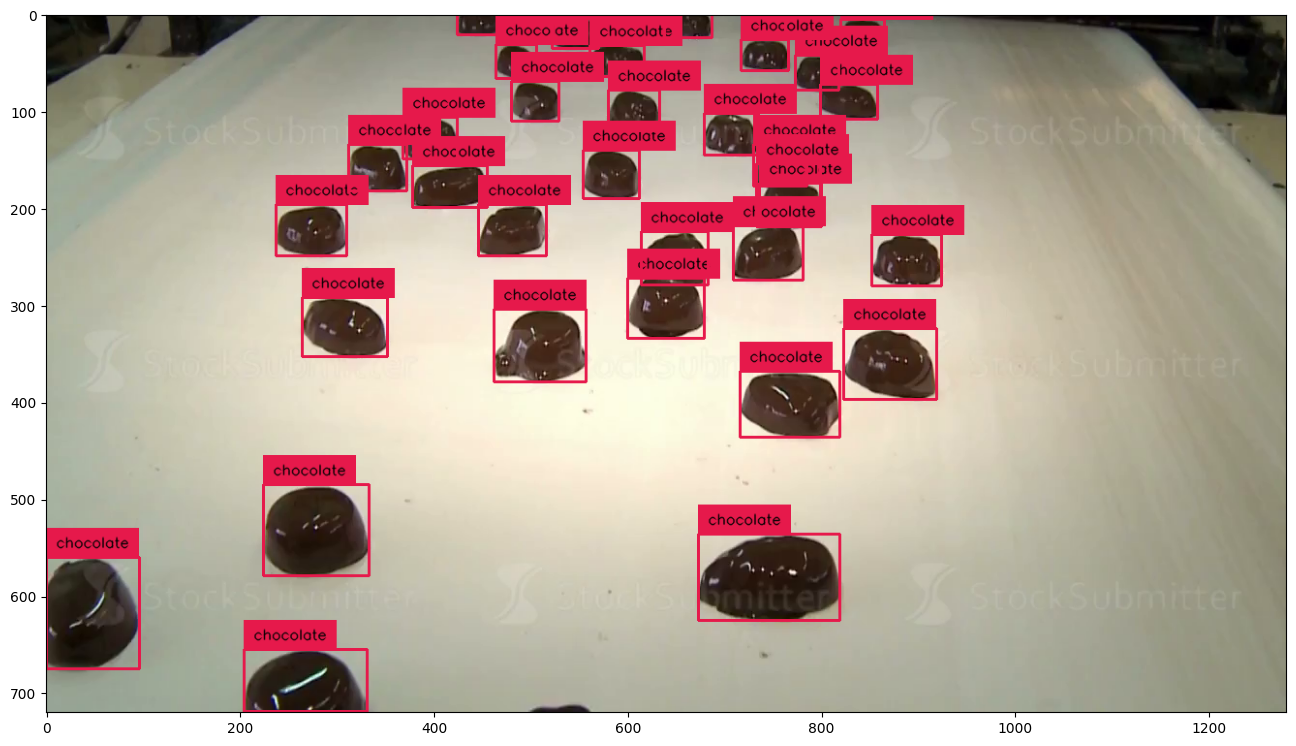

In [79]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=2, text_thickness=0, text_scale=0.5)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame, conf=0.7)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    # f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    "chocolate"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
# frame = box_annotator.annotate(frame=frame, detections=detections)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

In [81]:
from tqdm.notebook import tqdm


# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
# box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=2, text_thickness=0, text_scale=0.5)
line_annotator = LineCounterAnnotator(thickness=2, text_thickness=2, text_scale=1)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame, conf=0.7)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
                    # f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
                    "chocolate"
                    for _, confidence, class_id, tracker_id
                    in detections
                 ]
        # updating line counter
        line_counter.update(detections=detections)
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

  0%|          | 0/457 [00:00<?, ?it/s]


0: 384x640 34 chocolates, 7.9ms
Speed: 0.5ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 33 chocolates, 8.2ms
Speed: 0.4ms preprocess, 8.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 34 chocolates, 8.2ms
Speed: 0.5ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 33 chocolates, 9.0ms
Speed: 0.5ms preprocess, 9.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 33 chocolates, 7.9ms
Speed: 0.5ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 33 chocolates, 8.8ms
Speed: 0.4ms preprocess, 8.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 33 chocolates, 8.6ms
Speed: 0.4ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 32 chocolates, 9.1ms
Speed: 0.5ms preprocess, 9.1ms inference, 2.7ms postprocess per 